In [3]:
"""
Name: con_example.ipynb
Authors: Christian Haack, Stephan Meighen-Berger
Example of the realistic simulations that can be done
"""
%load_ext autoreload
%autoreload 2

In [4]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import yaml
from copy import deepcopy
from cProfile import Profile
import networkx as nx

In [5]:
# Adding path to module
sys.path.append("../")

In [6]:
# picture path
PICS = '../pics/'

In [7]:
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig

In [8]:
def get_node_communities(g):
    communities = []
    node_com_dict = {}
    for node in g:
        com = g.nodes[node]["community"]
        if not communities:
            communities.append(com)
            node_com_dict[node] = 0
        else:
            new_com = True
            for com_index, c in enumerate(communities):
                if node in c:
                    new_com = False
                    node_com_dict[node] = com_index
            if new_com:
                communities.append(com)
                node_com_dict[node] = len(communities)-1
    return communities, node_com_dict
            
                
        
    
    

In [9]:
my_config = yaml.safe_load(open("fitted_config.yaml"))
my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["population class"] = "HomogeneousPopulation"
my_config["population"]["social circle pdf"]["mean"] = 7.8
my_config["population"]["social circle pdf"]["sd"] = 0.1
my_config["population"]["social circle interactions pdf"]["mean"] = 7.8
my_config["population"]["social circle interactions pdf"]["sd"] = 0.1
my_config["population"]["population storage"] = "scenarios_graph.pickle"
my_config["population"]["nx"] = {}
my_config["population"]["nx"]["func"] = "lfr_ba"
my_config["population"]["nx"]["kwargs"] = {
                "m": 4,
                "tau": 1.2,
                "mu": 0.1,
                "min_community": 10,
                "max_community": 500,
                "max_iters": 2000,
                "tolerance": 0.1,
                "pref_attach": True
            }
my_config["population"]["nx"]["inter freq pdf"] = {
                "class": "Gamma",
                "mean": 7.8,
                "sd": 3
            }
my_config["population"]["nx"]["intra freq pdf"] = { 
                "class": "Gamma",
                "mean": 7.8,
                "sd": 3
            }
my_config["population"]["store_population"] = True
my_config["population"]["population size"] = 100000
my_config["population"]["re-use population"] = False
my_config["infection"]["infected"] = 10
my_config["population"]["random interactions pdf"]["mean"] = 0.01
my_config["population"]["random interactions pdf"]["sd"] = 0.01
my_config["population"]["random interactions intensity pdf"]["mean"] = 0.01
my_config["population"]["random interactions intensity pdf"]["sd"] = 0.001
my_config["scenario"]["sim_length"] = 720
"""
my_config["infection"]["hospitalization probability pdf"] = {
    "class": "Beta",
    "mean": 0.2,
    "sd": 0.01}
my_config["infection"]["hospitalization duration pdf"] = {"class": "Gamma",
    "mean": 12.,
    "sd": 3}
my_config["infection"]["time until hospitalization pdf"] = {"class": "Gamma",
    "mean": 7,
    "sd": 2.}
my_config["infection"]["time incubation death pdf"] = {
    "class": "Gamma",
    "mean": 20,
    "sd": 10.}
my_config["infection"]["mortality prob pdf"] = {
    "class": "Beta",
    "mean": 0.15,
    "sd": 0.01}
"""

'\nmy_config["infection"]["hospitalization probability pdf"] = {\n    "class": "Beta",\n    "mean": 0.2,\n    "sd": 0.01}\nmy_config["infection"]["hospitalization duration pdf"] = {"class": "Gamma",\n    "mean": 12.,\n    "sd": 3}\nmy_config["infection"]["time until hospitalization pdf"] = {"class": "Gamma",\n    "mean": 7,\n    "sd": 2.}\nmy_config["infection"]["time incubation death pdf"] = {\n    "class": "Gamma",\n    "mean": 20,\n    "sd": 10.}\nmy_config["infection"]["mortality prob pdf"] = {\n    "class": "Beta",\n    "mean": 0.15,\n    "sd": 0.01}\n'

In [10]:
yaml.dump(my_config, open("param_scan_config.yaml", "w"))

In [11]:
contagion = Contagion(my_config)
prof = Profile()
contagion.sim()
stats = pd.DataFrame(contagion.statistics)

In [65]:
my_config["population"]["re-use population"] = True
my_config["population"]["store population"] = False

In [66]:
results = []
t_durs = [None, 9*30, 14*30]
t_start = 30
t_dur_2 = 14
for t_dur in t_durs:
    this_config = deepcopy(my_config)
    if t_dur is None:
        this_config["scenario"]["class"] = "StandardScenario"
    else:    
        this_config["scenario"]["class"] = "SocialDistancing"
        this_config["scenario"]["t_steps"] = [t_start, t_start + 28, t_start + 28 +t_dur]
        this_config["scenario"]["contact_rate_scalings"] = [1/7.8, 2/7.8, 1]        
        
    contagion = Contagion(this_config)
    if hasattr(contagion.pop, "_graph"):
        g = deepcopy(contagion.pop._graph)
    else:
        g = None
    contagion.sim()
    stats = pd.DataFrame(contagion.statistics)
    results.append((stats, g, contagion.trace_contacts))
        
        

In [67]:
# Plotting standards
std_size = 10.
fontsize = 10.
lw=2.
h_length=1.

In [68]:
for (res, g, traced) in results:
    if g is None:
        continue
    communities, node_com_dict = get_node_communities(g)
    imp_on_day = []
    for day in traced:
        infected = np.unique(day)
        n_impacted = 0
        impacted = set()
        for node in infected:
            impacted.add(node_com_dict[node])
        imp_on_day.append(len(impacted))
    res["impacted_com"] = imp_on_day

In [2]:
results[0, 2]

NameError: name 'results' is not defined

<ipython-input-69-b3de49b67831>:11: RuntimeWarning: divide by zero encountered in double_scalars
  dbl_time.append((1/fit[0]*np.log(2)))
<ipython-input-69-b3de49b67831>:10: RuntimeWarning: divide by zero encountered in log
  fit = np.polyfit(np.arange(window_len), np.log(res["is_infected"].values[window]), 1)
<ipython-input-69-b3de49b67831>:11: RuntimeWarning: divide by zero encountered in double_scalars
  dbl_time.append((1/fit[0]*np.log(2)))
<ipython-input-69-b3de49b67831>:10: RuntimeWarning: divide by zero encountered in log
  fit = np.polyfit(np.arange(window_len), np.log(res["is_infected"].values[window]), 1)


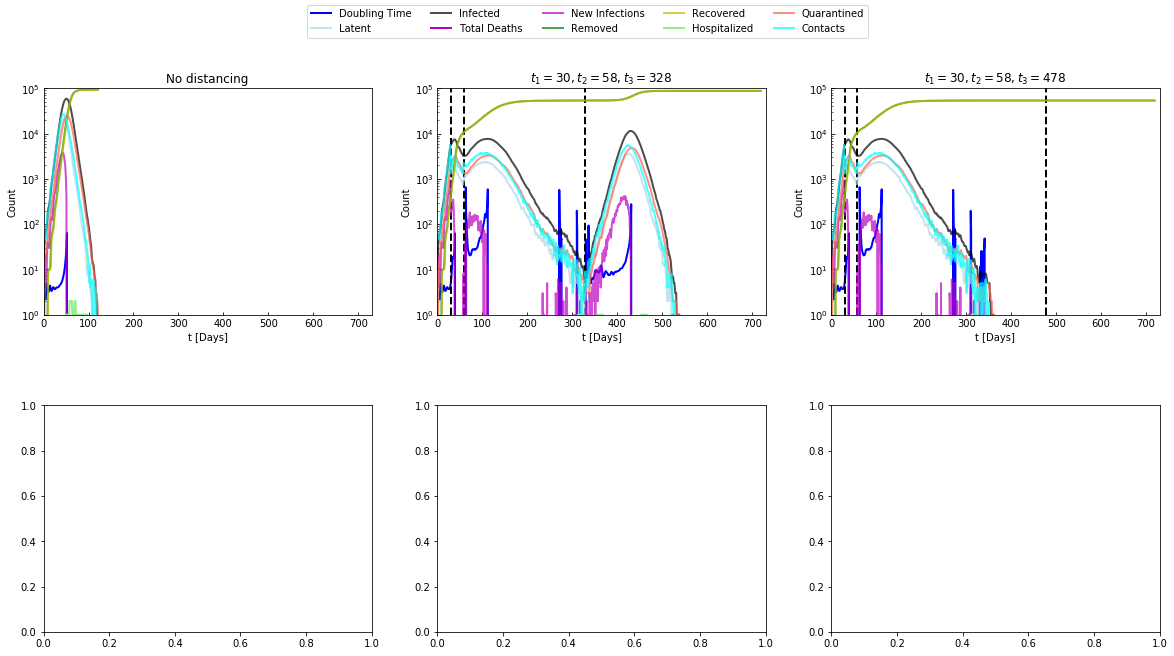

In [69]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for ts, (res, g, traced), ax in zip(t_durs, results, axs.ravel()):
     # Infections per time step
    tsteps = np.arange(len(res['is_latent']))
    
    dbl_time = []
    window_len = 7
    for i in range(window_len, len(res["is_infected"])):
        window = slice(i-window_len, i)
        fit = np.polyfit(np.arange(window_len), np.log(res["is_infected"].values[window]), 1)
        dbl_time.append((1/fit[0]*np.log(2)))
    ax.plot(np.arange(5, 5+len(dbl_time)), dbl_time, lw=lw,
            color="blue", label="Doubling Time")
    
    if ts is not None:
        ax.axvline(t_start, ls="--", lw=2, color="k")
        ax.axvline(28+t_start, ls="--", lw=2, color="k")
        ax.axvline(28+ts+t_start, ls="--", lw=2, color="k")
    ax.plot(tsteps, res['is_latent'],
            lw=lw, label='Latent', color="lightblue", alpha=0.7)
    ax.plot(tsteps, res['is_infected'],
            lw=lw, label='Infected', color="k", alpha=0.7)
    ax.plot(tsteps, res['is_dead'],
            lw=lw, label='Total Deaths', color="m")
    ax.plot(tsteps[1:], np.diff(res['is_infected']),
            lw=lw, label='New Infections', color="m", alpha=0.7)
    ax.plot(tsteps, res['is_removed'],
            lw=lw, label='Removed', color='g', alpha=0.7)
    ax.plot(tsteps, res['is_recovered'],
            lw=lw, label='Recovered', color='y', alpha=0.7)
    
    ax.plot(tsteps, res['is_hospitalized'],
            lw=lw, label='Hospitalized', color='lightgreen')
    ax.plot(tsteps, res['is_quarantined'],
            lw=lw, label='Quarantined', color='tomato', alpha=0.7)
    ax.plot(tsteps, res['contacts'],
            lw=lw, label='Contacts', color='cyan', alpha=0.7)
    if g is not None:
        ax.plot(tsteps, res["impacted_com"],
                lw=lw, label='Infected Communities', color='limegreen', alpha=0.7)
   
    ax.set_xlim(0, 2*365)
    ax.set_ylim(1., config["population"]['population size'] * 1.01)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlabel(r't [Days]', fontsize=fontsize)
    ax.set_ylabel(r'Count', fontsize=fontsize)
    ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    h, l = ax.get_legend_handles_labels()
    if ts is None:
        ax.set_title("No distancing")
    else:
        ax.set_title("$t_1 ="+str(t_start)+", t_2="+str(t_start+28)+", t_3="+str(t_start+28+ts)+"$")
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.2)  
plt.figlegend(h, l, ncol=5, loc="upper center")

plot_name = "Contagion_SocialDistancing_{}_{}_log.png".format(my_config["population"]["population class"], t_start)

plt.savefig(PICS + plot_name, bbox_inches='tight', dpi=150)

Text(0, 0.5, 'Uninfected')

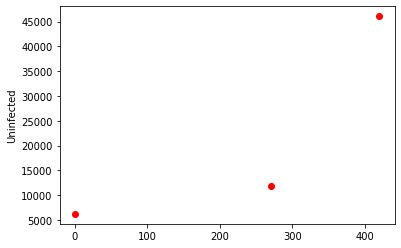

In [70]:
for ts, (res, g, traced) in zip(t_durs, results):
    if ts is None:
        ts = 0
    
    #plt.plot(ts, max(res['is_infected']), "ok")
    plt.plot(ts, 1E5-max(res['is_recovered']), "or")
#plt.semilogy()
plt.ylabel("Uninfected")

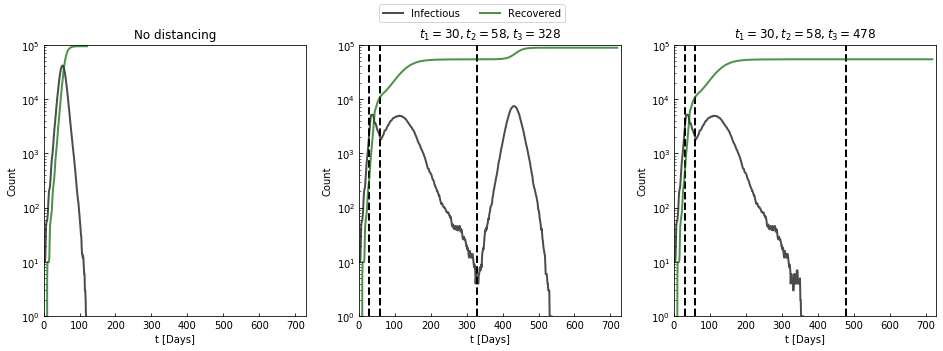

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for ts, (res, g, traced), ax in zip(t_durs, results, axs.ravel()):
     # Infections per time step
    tsteps = np.arange(len(res['is_latent']))
       
    if ts is not None:
        ax.axvline(t_start, ls="--", lw=2, color="k")
        ax.axvline(28+t_start, ls="--", lw=2, color="k")
        ax.axvline(28+ts+t_start, ls="--", lw=2, color="k")
    ax.plot(tsteps, res['is_infectious'],
            lw=lw, label='Infectious', color="k", alpha=0.7)
   
    ax.plot(tsteps, res['is_recovered'],
            lw=lw, label='Recovered', color='darkgreen', alpha=0.7)
    
   
   
    ax.set_xlim(0, 2*365)
    ax.set_ylim(1., config["population"]['population size'] * 1.01)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_xlabel(r't [Days]', fontsize=fontsize)
    ax.set_ylabel(r'Count', fontsize=fontsize)
    ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
    ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
    h, l = ax.get_legend_handles_labels()
    if ts is None:
        ax.set_title("No distancing")
    else:
        ax.set_title("$t_1 ="+str(t_start)+", t_2="+str(t_start+28)+", t_3="+str(t_start+28+ts)+"$")
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.2)  
plt.figlegend(h, l, ncol=5, loc="upper center")

plot_name = "Contagion_SocialDistancing_{}_{}_log_minimal.png".format(my_config["population"]["population class"], t_start)

plt.savefig(PICS + plot_name, bbox_inches='tight', dpi=150)

In [49]:
len(np.unique(np.hstack(contagion.trace_contacts)[0][:, 1]))

96380

In [72]:
node_com_dict[200]

9

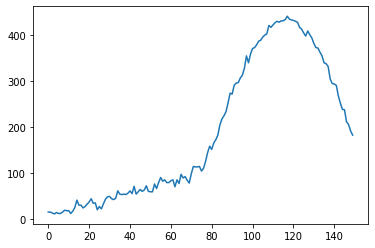

In [75]:
plt.plot(imp_on_day)

In [89]:
com_graph = nx.Graph()
com_graph.add_nodes_from(range(len(communities)))

for i, com in enumerate(communities):
    con_coms = set()
    for node in com:
        adjs = g[node]
        for adj in adjs:
            con_coms.add(node_com_dict[adj])
    for con_com in con_coms:
        com_graph.add_edge(i, con_com)
        



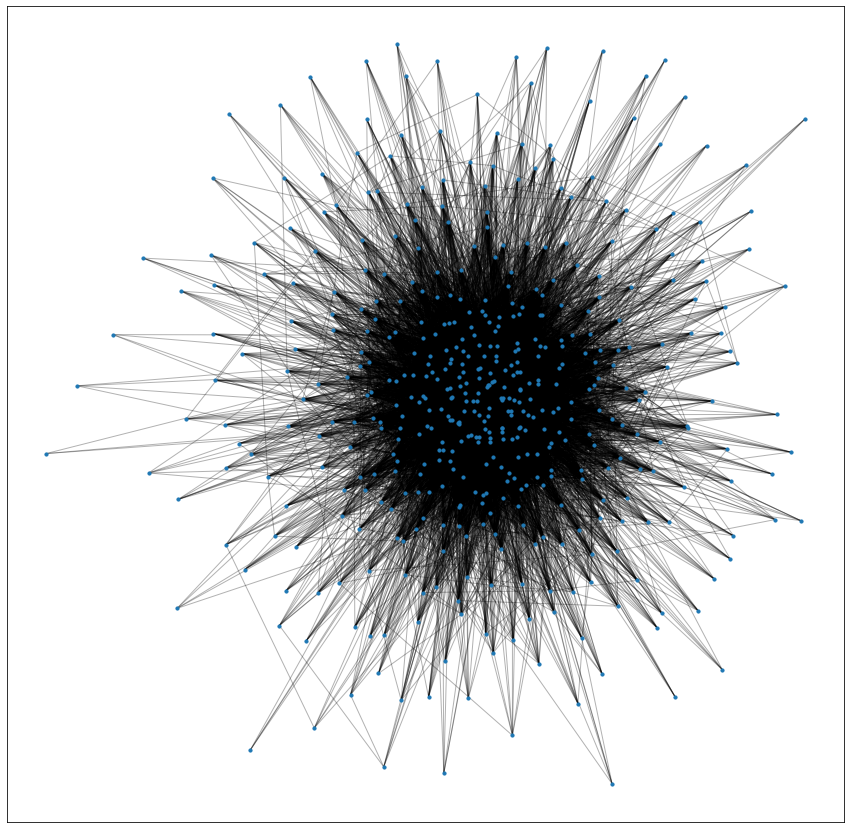

In [92]:
fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(com_graph)
nx.draw_networkx_nodes(com_graph, pos, node_size=10)
nx.draw_networkx_edges(com_graph, pos, width=1, alpha=0.3)

In [56]:
print(len(contagion.trace_contacts))

150


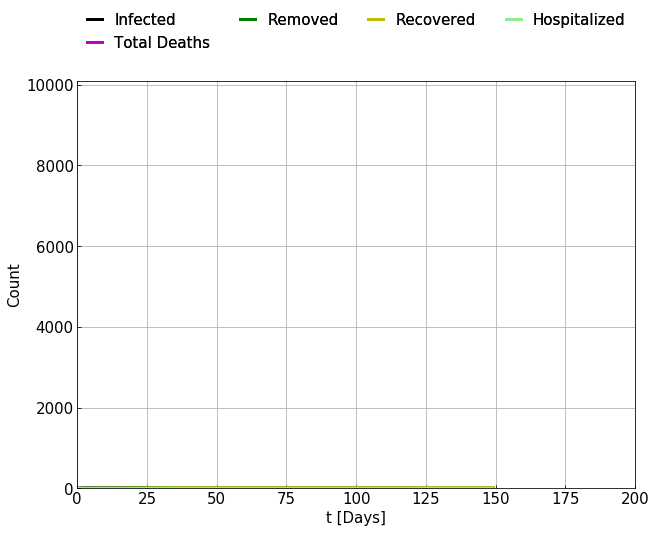

In [40]:
 # Infections per time step
figure, ax = plt.subplots(figsize=(std_size, std_size * 6. / 8.))

ax.plot(contagion.t, stats['is_infected'],
        lw=lw, label='Infected', color="k")
ax.plot(contagion.t, stats['is_dead'],
        lw=lw, label='Total Deaths', color="m")
ax.plot(contagion.t, stats['is_removed'],
        lw=lw, label='Removed', color='g')
ax.plot(contagion.t, stats['is_recovered'],
        lw=lw, label='Recovered', color='y')
ax.plot(contagion.t, stats['is_hospitalized'],
        lw=lw, label='Hospitalized', color='lightgreen')

ax.set_xlim(0, 200)
ax.set_ylim(0., config["population"]['population size'] * 1.01)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r't [Days]', fontsize=fontsize)
ax.set_ylabel(r'Count', fontsize=fontsize)
ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax.get_legend_handles_labels()
lgd1 = ax.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                 ncol=4, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax.add_artist(lgd1)
plt.grid(True)
plt.show()

In [ ]:
 # Infections per time step
figure, ax = plt.subplots(figsize=(std_size, std_size * 6. / 8.))
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
ax.plot(contagion.t, stats['is_infectious'],
        lw=lw, label='Infectious', color='r')
ax.plot(contagion.t, stats['can_infect'],
        lw=lw, label='Can infect', color='lightgrey')
ax.plot(contagion.t, stats['is_latent'],
        lw=lw, label='Latent', color='lightblue')
ax.plot(contagion.t, stats['is_incubation'],
        lw=lw, label='Incubation', color='b')
ax.plot(contagion.t, stats['is_infected'],
        lw=lw, label='Infected', color="k")
ax.plot(contagion.t, stats['is_dead'],
        lw=lw, label='Total Deaths', color="m")
ax.plot(contagion.t, stats['is_removed'],
        lw=lw, label='Removed', color='g')
ax.plot(contagion.t, stats['is_recovered'],
        lw=lw, label='Recovered', color='y')
ax.plot(contagion.t, stats['is_hospitalized'],
        lw=lw, label='Hospitalized', color='lightgreen')
ax.plot(contagion.t, stats['is_symptomatic'],
        lw=lw, label='Symptomatic', color='lightcoral')
ax.set_xlim(0, 200)
ax.set_ylim(0., config["population"]['population size'] * 1.01)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r't [Days]', fontsize=fontsize)
ax.set_ylabel(r'Count', fontsize=fontsize)
ax.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax.get_legend_handles_labels()
lgd1 = ax.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                 ncol=4, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax.add_artist(lgd1)
plt.grid(True)
plt.show()

In [12]:
figure.savefig(PICS + "Contagion_Example.png",
               bbox_inches='tight')